**Introduction**

This project fine-tunes a pre-trained large language model (LLM), FLAN-T5, to build a medical chatbot capable of handling patient-doctor dialogues. Fine-tuning is done using Parameter Efficient Fine-Tuning (PEFT), particularly through Low-Rank Adaptation (LoRA) and QLoRA. This approach drastically reduces the number of trainable parameters and memory footprint while maintaining model performance. The results are evaluated using the ROUGE and BLEU metrics.

**Installations & Imports**


In [ ]:
#Displaying NVIDIA GPU Information using nvidia-smi Command
!nvidia-smi

Sat Sep  7 13:08:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              31W /  70W |  11501MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Installing PyTorch, TorchVision, and TorchAudio Libraries
!pip3 install torch torchvision torchaudio

In [ ]:
#Installing and Upgrading BitsAndBytes, Transformers, PEFT, and Accelerate Libraries

!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Upgrading and Installing the Datasets Library
!pip install -U datasets

In [ ]:
#Installing the Evaluate Library
%pip install evaluate

In [ ]:
# Installing and Upgrading the TRL (Transformers Reinforcement Learning) Library
%pip -q install -U trl

In [ ]:
# Installing Specific Versions of Rouge Score and Loralib Libraries
%pip install \
    rouge_score==0.1.2 \
    loralib==0.1.1 --quiet

In [ ]:
# Importing Necessary Libraries for NLP, Model Training, and Evaluation
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig, GenerationConfig, TrainingArguments, Trainer
from peft import PeftModel, PeftConfig
from datasets import load_dataset
from trl import SFTTrainer, setup_chat_format

import evaluate

from tqdm import tqdm

import matplotlib.pyplot as plt

import os
import shutil
import time
import pandas as pd
import numpy as np
import random

In [ ]:
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Data set information**

The dataset is "ruslanmv/ai-medical-chatbot" from Hugging Face, which contains dialogues between patients and doctors. A subset of 1000 samples is selected to reduce processing time.

In [ ]:
# Loading and Preparing a Medical Chatbot Dataset for Model Training
dataset_name = "ruslanmv/ai-medical-chatbot"
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.shuffle(seed=65).select(range(1000)) #Shuffling the dataset,Only using 1000 samples for quick demo

In [ ]:
#Splitting the Dataset into Training and Test Sets (90% Training, 10% Testing)
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
# splits the dataset into two subsets:Train and Test
dataset

DatasetDict({
    train: Dataset({
        features: ['Description', 'Patient', 'Doctor'],
        num_rows: 900
    })
    test: Dataset({
        features: ['Description', 'Patient', 'Doctor'],
        num_rows: 100
    })
})

### 2.1 Samples from datasets

The dataset has been divided into three parts


*   Train
*   Test
*   Validation

and can accessed by giving dict key value pairs. Some of the samples are as following



In [ ]:
# Assuming you have three separate lists or arrays for train, test, and validation data
train_data = dataset['train']
test_data = dataset['test']

# Generate random indices for each set
train_index = random.randint(0, len(train_data) - 1)
test_index = random.randint(0, len(test_data) - 1)

# Retrieve dialogue and summary for the random indices
random_train_dialogue = train_data[train_index]['Patient']
random_train_summary = train_data[train_index]['Doctor']

random_test_dialogue = test_data[test_index]['Patient']
random_test_summary = test_data[test_index]['Doctor']

# Print the results
print("Randomly selected train Patient:")
print(random_train_dialogue)
print("Randomly selected train Doctor:")
print(random_train_summary)

print('-'.join('' for x in range(100)))

print("\nRandomly selected test Patient:")
print(random_test_dialogue)
print("Randomly selected test Doctor:")
print(random_test_summary)

print('-'.join('' for x in range(100)))


Randomly selected train Patient:
I am 33 yrs old, had a hysterectomy at 32 years old (over a year ago) and it was a total hyst. I just went to the bathroom and my urine appeared to be of normal color however when I wiped there was pink on my toilet paper after wiping three times. The last time I had sex with my husband was approx. 3 days ago so I know he did not rip me or scratch anything (I normally tear). I have had a little cramping but nothing major. What could this be caused from? Could it be a bladder, kidney infection or a UTI or something else more so serious as they took my uterus and ovaries? Thanks!
Randomly selected train Doctor:
Helloyes it can be due to UTI though it most commonly causes BURNING SENSATION DURING MICTURITION...u should get a complete urine examination and ultrasound of kub region
---------------------------------------------------------------------------------------------------

Randomly selected test Patient:
Sir, MY father used to have problems with his 

### 2.2 - Preprocess the Dataset

Formatting the dataset into **Prompt -- Response** pairs

In [ ]:
#Specifying the Model Name for Fine-Tuning
model_name='google/flan-t5-base'

#Setting torch_dtype=torch.bfloat16 specifies the memory type to be used by this model
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    """Tokenizes the input and output text for a summarization example.

    Args:
        example (dict): A summarization example, with the following keys:
            * dialogue (list): A list of strings, representing the conversation to be summarized.
            * summary (str): The summary of the conversation.

    Returns:
        example (dict): The same example, with the following additional keys:
            * input_ids (torch.Tensor): The tokenized input text.
            * labels (torch.Tensor): The tokenized output text.
    """

    start_prompt = 'User:\n\n'
    end_prompt = '\n\nResponse: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["Patient"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["Doctor"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1614: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Description', 'Patient', 'Doctor',])

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
print(f"Shapes of the datasets:")
# print(f"Training: {tokenized_datasets.shape}")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (900, 2)
Test: (100, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 900
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 100
    })
})


## 3. Loading Pretrained LLM
FLAN-T5: Pre-trained transformer model known for handling instruction-based tasks. It is loaded from Hugging Face in bfloat16 precision (a memory-efficient format).
Load the pre-trained [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) model and its tokenizer directly from HuggingFace. Notice that you will be using the base version of FLAN-T5.

In [ ]:
model_name='google/flan-t5-base'

#Setting torch_dtype=torch.bfloat16 specifies the memory type to be used by this model
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

## 4. Testing Model without Fine-Tuning

Testing the base model without fine-tuning using some test examples from the dataset to define the baseline to which we'll compare the fine-tunined version.

In [ ]:
# Accessing Test Dataset Samples
Patient = dataset['test'][1]['Patient']
response = dataset['test'][1]['Doctor']

In [ ]:
print("Selected test Patient:")
print(Patient)
print("Selected test response:")
print(response)

Selected test Patient:
I have a psoriasis scar on my face it ocassional flares I'm thinking of using ambi skin bleachCream to lighten it, I used to scratch it inn my sleep and I'm wondering if the skin bleaching cream will worsen it instead of lightening this embarrassing scar
Selected test response:
Hi there,Thanks for posting here.You appear to have a post inflammatory hyperpigmentation on face.Avoid bleaches as they may cause more damage.Use a good suscreen with SPF30 daily morning. you can use a mild skin lightening cream containing vitamin c and kojic acid at night.Take care.Hope this helps you.Regards,Dr Shilpa BhatM.D DermatologyBangalore


In [ ]:
# Creating a prompt so that we can pass it to the model
prompt = f"""
Patient:

{Patient}

Response:
"""

In [ ]:
# Tokenize the input text using the tokenizer
inputs = tokenizer(prompt, return_tensors='pt').to(device)

# Generate text using the original model and store the prediction
pred = original_model.generate(inputs["input_ids"], max_new_tokens=200,)[0]

# Decode the generated token IDs into human-readable text, skipping special tokens
output = tokenizer.decode(pred, skip_special_tokens=True)


In [ ]:
# Results

print('-'.join('' for x in range(100)))
print(f'INPUT PROMPT:\n{prompt}')
print('-'.join('' for x in range(100)))
print(f'BASELINE Doctor Response:\n{response}\n')
print('-'.join('' for x in range(100)))
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Patient:

I have a psoriasis scar on my face it ocassional flares I'm thinking of using ambi skin bleachCream to lighten it, I used to scratch it inn my sleep and I'm wondering if the skin bleaching cream will worsen it instead of lightening this embarrassing scar

Response:

---------------------------------------------------------------------------------------------------
BASELINE Doctor Response:
Hi there,Thanks for posting here.You appear to have a post inflammatory hyperpigmentation on face.Avoid bleaches as they may cause more damage.Use a good suscreen with SPF30 daily morning. you can use a mild skin lightening cream containing vitamin c and kojic acid at night.Take care.Hope this helps you.Regards,Dr Shilpa BhatM.D DermatologyBangalore

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:

### 4.1 Evaluation


In [ ]:
# Loading Evaluation Metrics for Model Performance
rouge_metric = evaluate.load('rouge')
bleu_metric = evaluate.load('bleu')

In [ ]:
# getting all 1000 values from the test dataset
patient = dataset['test'][:1]['Patient']
baseline_response = dataset['test'][:1]['Doctor']

In [ ]:
len(patient), len(baseline_response)

(1, 1)

In [ ]:
original_model_response = []

In [ ]:
# Generating Model Responses for Patient Dialogues

for i, x in tqdm(enumerate(patient), desc="Processing dialogues"):
    prompt = f"""
                Patient:

                {x}

                Response:
             """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_response.append(original_model_text_output)


Processing dialogues: 1it [00:02,  2.24s/it]


In [ ]:
zipped_summaries = list(zip(baseline_response, original_model_response))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_response', 'original_model_response'])
df.head()

,human_baseline_response,original_model_response
0,This is really a funny thing..... what made h...,The patient is my younger brother who got marr...


In [ ]:
len(original_model_response)

1

In [ ]:
# Compute the ROUGE metrics
original_model_results = rouge_metric.compute(
    predictions=original_model_response,
    references=baseline_response[0:len(original_model_response)],
    use_aggregator=True,
    use_stemmer=True,
)

In [ ]:
print('ORIGINAL MODEL ROUGE RESULTS:')
print(original_model_results)

ORIGINAL MODEL ROUGE RESULTS:
{'rouge1': 0.18461538461538463, 'rouge2': 0.0, 'rougeL': 0.13846153846153844, 'rougeLsum': 0.13846153846153844}


In [ ]:
# original_model_results_scores = [x for _, x in original_model_results.items()]
# labels = [x for x, _ in original_model_results.items()]

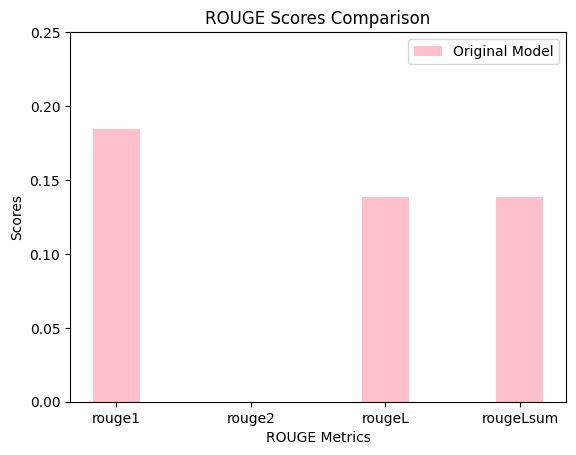

In [ ]:
# Visualizing ROUGE Scores Comparison with Bar Graph

import matplotlib.pyplot as plt

original_model_results_scores = [x for _, x in original_model_results.items()]
labels = [x for x, _ in original_model_results.items()]

# Bar width
bar_width = 0.35

# X-axis positions
x = range(len(labels))

# Create bar graph
plt.bar(x, original_model_results_scores, width=bar_width,color = "pink", label='Original Model', align='center')

# Labels and title
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores Comparison')

# Fixing x-ticks
plt.xticks(x, labels)
plt.ylim(0, 0.25)

plt.legend()

# Show the plot
plt.show()


## 5. Parameter Efficient Fine-Tuning (PEFT)


**PEFT** [Parameter-Efficient Fine-Tuning (PEFT) ](https://huggingface.co/docs/peft/index) is a technique to fine-tune LLMs with a small number of trainable parameters, making it computationally efficient. LoRA is one  technique that only updates certain matrices in the model rather than fine-tuning all parameters.

**Low-rank adaptation (LoRA)**: LoRA is a technique that uses a low-rank matrix to encode the changes needed to fine-tune a pre-trained language model for a new task. LoRA is very efficient, as it only requires training a small number of parameters,
while [QLoRA](https://github.com/artidoro/qlora) is an even more memory-efficient version of LoRA where the pre-trained model is loaded to GPU memory as quantized 4-bit weights (compared to 8-bits in the case of LoRA)




### 5.1 Loading 4bit quantized model

In [ ]:
model_name='google/flan-t5-base'

In [ ]:
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_use_double_quant=True,
# )

In [ ]:
# Loading a Pretrained Seq2Seq Model with 4-bit Quantization and Mixed Precision
model = AutoModelForSeq2SeqLM.from_pretrained(
    pretrained_model_name_or_path=model_name,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type='nf4'
    ),
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1614: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Enabling Gradient Checkpointing and Preparing the Model for k-bit (Quantized) Training

from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

### 5.2 - Setup the PEFT/LoRA model for Fine-Tuning

The below code configures LoRA (Low-Rank Adaptation) for fine-tuning a sequence-to-sequence (Seq2Seq) model, such as FLAN-T5. LoRA is a technique that introduces low-rank decomposition to reduce the number of trainable parameters, making it more efficient to fine-tune large models on downstream tasks.

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
peft_model = get_peft_model(model, lora_config)

# peft_model = get_peft_model(original_model, lora_config)
print(print_trainable_parameters(peft_model))

trainable params: 3538944 || all params: 170900736 || trainable%: 2.070759952724838
None


In [ ]:
output_dir = f'./peft-qlora-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
        per_device_train_batch_size = 32,
        warmup_steps=2,
        num_train_epochs=2,
        max_steps=500,
        learning_rate=2e-4,
        logging_steps=1,
        output_dir=output_dir,
        optim="paged_adamw_8bit"
)


In [ ]:
torch.cuda.empty_cache()

# Run garbage collector
import gc
gc.collect()

30

In [ ]:
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets['train'],
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# Training the Model and Saving the Fine-Tuned Model and Tokenizer
peft_trainer.train()

peft_model_path="./peft-qlora-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

Step,Training Loss
1,2.137400
2,2.020500
3,2.084200
4,2.094500
5,2.008100
6,2.013500
7,1.916800
8,1.913500
9,1.967600
10,1.974000


('./peft-qlora-checkpoint-local/tokenizer_config.json',
 './peft-qlora-checkpoint-local/special_tokens_map.json',
 './peft-qlora-checkpoint-local/spiece.model',
 './peft-qlora-checkpoint-local/added_tokens.json',
 './peft-qlora-checkpoint-local/tokenizer.json')

In [ ]:
peft_model_path


'./peft-qlora-checkpoint-local'

In [ ]:
# Define the name of the output zip file
zip_file_name = "peft_model.zip"

# Create a zip file
shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', peft_model_path)

# Move the zip file to the Colab's download directory
shutil.move(zip_file_name.replace('.zip', '') + '.zip', '/content/' + zip_file_name)


'/content/peft_model.zip'

In [ ]:
# Provide a download link for the zip file
from google.colab import files
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
peft_model = '/content/peft-qlora-checkpoint-local'

In [ ]:
from peft import PeftModel, PeftConfig

model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

#Combining the adapter and model
peft_model = PeftModel.from_pretrained(model_base, #base model
                                       peft_model, #PEFT Adaptor
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1614: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(print_trainable_parameters(peft_model))

trainable params: 0 || all params: 251116800 || trainable%: 0.0
None


In [ ]:
# getting all 1000 values from the test dataset
patient = dataset['test'][:1]['Patient']
baseline_response = dataset['test'][:1]['Doctor']

In [ ]:
finetuned_model_response = []

In [ ]:

#Generating and Collecting Responses from the Fine-Tuned PEFT Model

for i, x in tqdm(enumerate(patient), desc="Processing dialogues"):
    prompt = f"""
                Patient:

                {x}

                Response:
             """


    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    # original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
    # original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    # original_model_response.append(original_model_text_output)
    finetuned_model_response.append(peft_model_text_output)


Processing dialogues: 1it [00:00,  1.52it/s]


In [ ]:
# Creating a DataFrame to Compare Human, Original Model, and Fine-Tuned Model Responses

zipped_summaries = list(zip(baseline_response, original_model_response, finetuned_model_response))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_response', 'original_model_response', 'finetuned_model_response'])
df.head()

,human_baseline_response,original_model_response,finetuned_model_response
0,This is really a funny thing..... what made h...,The patient is my younger brother who got marr...,Hypnotist available in Chennai who can help yo...


In [ ]:
# Compute the ROUGE metrics for Fine-Tuned Model Evaluation
fine_tuned_model_results = rouge_metric.compute(
    predictions=finetuned_model_response,
    references=baseline_response[0:len(finetuned_model_response)],
    use_aggregator=True,
    use_stemmer=True,
)

In [ ]:
fine_tuned_model_results

{'rouge1': 0.07272727272727272,
 'rouge2': 0.0,
 'rougeL': 0.03636363636363636,
 'rougeLsum': 0.03636363636363636}

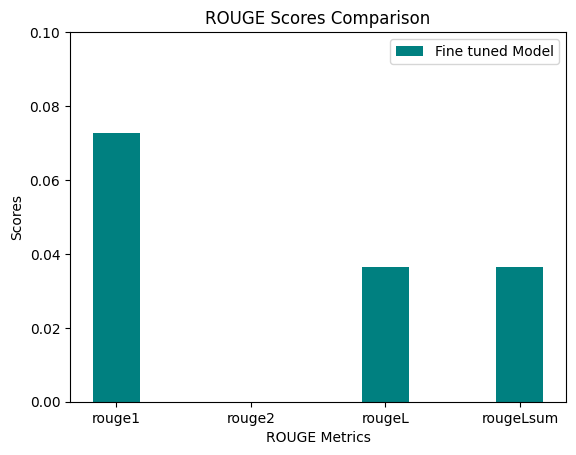

In [ ]:

# Plotting ROUGE Scores for the Fine-Tuned Model

import matplotlib.pyplot as plt

fine_tuned_model_results_scores = [x for _, x in fine_tuned_model_results.items()]
labels = [x for x, _ in original_model_results.items()]

# Bar width
bar_width = 0.35

# X-axis positions
x = range(len(labels))

# Create bar graph
plt.bar(x, fine_tuned_model_results_scores, width=bar_width,color ="teal", label='Fine tuned Model', align='center')

# Labels and title
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores Comparison')

# Fixing x-ticks
plt.xticks(x, labels)
plt.ylim(0, 0.10)
plt.legend()

# Show the plot
plt.show()


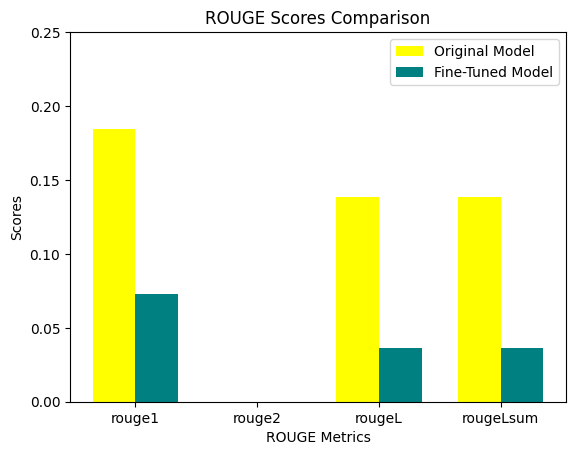

In [ ]:
# Comparing ROUGE Scores: Original Model vs. Fine-Tuned Model

import matplotlib.pyplot as plt

# Original and fine-tuned model results
original_model_results_scores = [x for _, x in original_model_results.items()]
fine_tuned_model_results_scores = [x for _, x in fine_tuned_model_results.items()]
labels = [x for x, _ in original_model_results.items()]

# Bar width
bar_width = 0.35

# X-axis positions for original model bars
x = range(len(labels))

# X-axis positions for fine-tuned model bars
x_fine_tuned = [pos + bar_width for pos in x]

# Create bar graphs for both models
plt.bar(x, original_model_results_scores, width=bar_width,color="yellow", label='Original Model', align='center')
plt.bar(x_fine_tuned, fine_tuned_model_results_scores, width=bar_width,color="teal", label='Fine-Tuned Model', align='center')

# Labels and title
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores Comparison')

# Fixing x-ticks
plt.xticks([pos + bar_width / 2 for pos in x], labels)
plt.ylim(0, 0.25)

# Add legend
plt.legend()

# Show the plot
plt.show()
